# Trabalho prático da discplina de redes neurais
SCC0270 - Redes Neurais e Aprendizado Profundo (2023)
Professor: Diego Furtado Silva

---

Grupo:
*   Felipe Tetzner - 9897870
*   Paulo Henrique Sebastião de Moura - 10310471
*   Pedro Henrique Freitas Maiorano - 12701748


O projeto tem como finalidade a implementação em python de uma rede neural convolucional denominada por DenseNet.

Referência: https://arxiv.org/pdf/1608.06993v5.pdf

O artigo de referência propõe 4 variações da DenseNet como enunciado abaixo




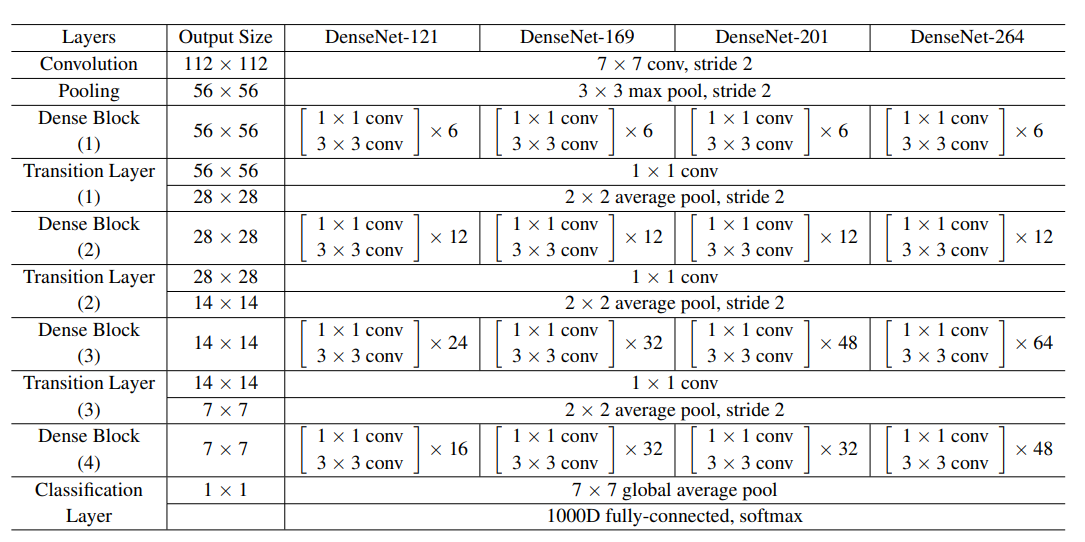

Como é possível observar essa Net possui uma estrutura bem definida



1.   Convolução
2.   Pooling
3.   Dense Block (1)
4.   Camada de transição (1)
5.   Dense Block (2)
6.   Camada de Transição (2)
7.   Dense Block (3)
8.   Camada de Transição (3)
9.   Dense Block (4)
10.  Camada de classificação



*   Dense Block: É um bloco de N blocos de convolucionais, essencialmente é formado duas convolucionais , 1x1 e 3x3 respectivamente, N vezes.



*   Camada de Transição: Consiste em fazer uma convolução 1x1 seguide de uma average pooling


Vale ressaltar que um dos problemas de redes neurais muito profundas( muitas camadas) é a perda de informação ao longo das camadas, mas para a criação da DenseNet foi introduzido um mecanismo que diminui esse impacto da profundidade, além de suavizar a descida do gradiente.

Esse mecanismo nada mais é do que, dentro um Dense Block o neurôrnio anterior leva a informação para todos os nerôes seguintes como mostra a imagem abaixo


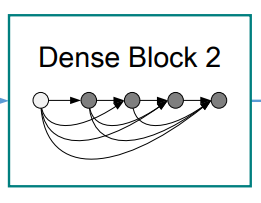



Essa rede também conta com inserção de batch normalization após as convoluções e suas funções de ativações são a ReLU.

Sobre o treino é utilizado o algoritmo de retro propagação e para otimização é feito uso do algoritmo de descida do gradiente estocástica

# DenseNet-27 Implementação

## Bibliotecas e preparando o ambiente

In [76]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


os.chdir(os.path.expanduser("~"))

In [77]:
torch.cuda.is_available()

True

## Preparando os dados

Dimensão da imagem (224,224)

In [78]:


# Criar um objeto ImageFolder
dataset = ImageFolder("train")

# Obter o caminho para uma imagem específica no dataset
image_path = dataset.imgs[0][0]  # Exemplo: primeira imagem do dataset

# Abrir a imagem usando PIL
image = Image.open(image_path)

# Obter o tamanho da imagem
image_size = image.size
print(image_size)
#necessário resize

(224, 224)


Transformações dos dados

In [79]:
mean = [0.485, 0.456, 0.406]  # Médias dos canais R, G e B nas imagens do conjunto de treinamento
std = [0.229, 0.224, 0.225]  # Desvios padrão dos canais R, G e B nas imagens do conjunto de treinamento

transforms_treino_1 = torchvision.transforms.Compose([
       torchvision.transforms.ToTensor(), #Transforma em tensor
       torchvision.transforms.Normalize(mean=mean, std=std)  #Normaliza os pixels
])

transforms_treino_2 = torchvision.transforms.Compose([
       torchvision.transforms.RandomHorizontalFlip(), #Espelha a imagem aleatoriamente
       torchvision.transforms.RandomRotation(25), #Rotaciona a imagem em (-25,25) graus
       torchvision.transforms.ToTensor(),
       torchvision.transforms.Normalize(mean=mean, std=std)  
])

transforms_treino_3 = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(25),
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])


transforms_treino_4 = torchvision.transforms.Compose([
       torchvision.transforms.RandomHorizontalFlip(),
       torchvision.transforms.RandomRotation(30),
       torchvision.transforms.Grayscale(),
       torchvision.transforms.GaussianBlur(kernel_size=3),
       torchvision.transforms.ToTensor(),
       torchvision.transforms.Normalize(mean=mean, std=std)  
])





transforms_validacao = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

transforms_teste = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])



Batch size + criação do dataloader(treino,validação e teste)

In [80]:
#batches
batch_size = 64



trainset_1 = torchvision.datasets.ImageFolder("train", transform = transforms_treino_1)
trainset_2 = torchvision.datasets.ImageFolder("train", transform = transforms_treino_2)
trainset_3 = torchvision.datasets.ImageFolder("train", transform = transforms_treino_3)
trainset_4 = torchvision.datasets.ImageFolder("train", transform = transforms_treino_4)

validset = torchvision.datasets.ImageFolder("valid", transform = transforms_validacao)
testset = torchvision.datasets.ImageFolder("test", transform = transforms_teste)





trainloader_1 = torch.utils.data.DataLoader(trainset_1 , batch_size=batch_size , shuffle = True)
trainloader_2 = torch.utils.data.DataLoader(trainset_2 , batch_size=batch_size , shuffle = True)
trainloader_3 = torch.utils.data.DataLoader(trainset_3 , batch_size=batch_size , shuffle = True)
trainloader_4 = torch.utils.data.DataLoader(trainset_4 , batch_size=batch_size , shuffle = True)


validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = False)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

## A rede

Alguns Hiperparâmetros

In [81]:
in_channels, growth_rate = 64, 32
tamanho_bottleneck = [2,4,3,2]
camada_intermediaria = []
torch.manual_seed(123)
loss_fn = nn.CrossEntropyLoss()

Camada inicial

In [82]:
## Camada inicial ##
## (BN - Relu - Conv)  + Max pool ##

camada_inicial = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(7,7), stride=2, padding=3), # convolucional
    nn.BatchNorm2d(64), #batch normalization
    nn.ReLU(), # relu ativação
    nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=1)) # Max pool


Bottleneck

In [83]:
## Bottleneck Block (mini bloco) ~ compõe o bloco denso ##
## (BN - Relu - Conv) + dropout + (BN - Relu - Conv) + dropout ##

def bottleneck(in_channels, out_channels, dropout=0.2):
    k = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels, out_channels, kernel_size=(1,1), padding=0, stride=1),
        nn.Dropout(p=dropout),

        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), padding=1, stride=1),
        nn.Dropout(p=dropout))
    return k


Dense Block

In [84]:
## Dense Block (Bloco denso) ##
## União de várias Bottleneck Block (mini blocos) ##

class DenseBlock(nn.Module):
    def __init__(self, tamanho, in_channels, growth_rate):
        super().__init__()
        self.net = nn.Sequential()
        for i in range(tamanho):
            self.net.add_module(f'bottleneck_{i+1}', bottleneck(in_channels + i * growth_rate, growth_rate))

    def forward(self, X):
        for SS in self.net:
            Y = SS(X)
            X = torch.cat((X, Y), dim=1)
        return X




Transition Block

In [85]:
## Transition Block (Bloco de transição) ##
## (BN - Relu - Conv) + dropout + Average Pooling

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.2):
        super().__init__()

        self.batch_norm = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1,
                               padding=0, bias=False)

        self.dropout = nn.Dropout(p=dropout)

        self.avgpool = nn.AvgPool2d(kernel_size=(2,2), stride = 2)

    def forward(self, x):
        saida = self.conv1(self.relu(self.batch_norm(x)))

        saida = self.dropout(saida)

        saida = self.avgpool(saida)

        return saida

Camada intermediária ( Bloco Denso + Transition + Bloco denso ...)


In [86]:
## Camada intermediária ##
## Junção de dense block + transition + dense block ##


for i, tamanho in enumerate(tamanho_bottleneck):
    camada_intermediaria.append(DenseBlock(tamanho, in_channels, growth_rate))

    in_channels += tamanho * growth_rate

    if i != len(tamanho_bottleneck) - 1:
        camada_intermediaria.append(Transition(in_channels, in_channels // 2))
        in_channels = in_channels // 2


Camada Final 

In [87]:
## Classification Layer (Camada de classificação) ##
## BN + Relu + Global AVG Pool + Flatten (diminuir a dimensão) + fully connected ##
camada_final = nn.Sequential(
    nn.BatchNorm2d(in_channels),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(in_channels, 70))


DenseNet-27 = Camada inicial > Camada intermediária > Camada final

In [88]:
## DenseNet ##
## Junção de tomas as camadas anteriores ##

DenseNet = nn.Sequential(
    camada_inicial,
    *camada_intermediaria,
    camada_final)

In [89]:
model = DenseNet

# Imprima as dimensões de entrada e saída de cada camada
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        print(f"{name}: Input shape = {module.weight.shape[1:]}, Output shape = {module.weight.shape[0]}")


0.0: Input shape = torch.Size([3, 7, 7]), Output shape = 64
1.net.bottleneck_1.2: Input shape = torch.Size([64, 1, 1]), Output shape = 32
1.net.bottleneck_1.6: Input shape = torch.Size([32, 3, 3]), Output shape = 32
1.net.bottleneck_2.2: Input shape = torch.Size([96, 1, 1]), Output shape = 32
1.net.bottleneck_2.6: Input shape = torch.Size([32, 3, 3]), Output shape = 32
2.conv1: Input shape = torch.Size([128, 1, 1]), Output shape = 64
3.net.bottleneck_1.2: Input shape = torch.Size([64, 1, 1]), Output shape = 32
3.net.bottleneck_1.6: Input shape = torch.Size([32, 3, 3]), Output shape = 32
3.net.bottleneck_2.2: Input shape = torch.Size([96, 1, 1]), Output shape = 32
3.net.bottleneck_2.6: Input shape = torch.Size([32, 3, 3]), Output shape = 32
3.net.bottleneck_3.2: Input shape = torch.Size([128, 1, 1]), Output shape = 32
3.net.bottleneck_3.6: Input shape = torch.Size([32, 3, 3]), Output shape = 32
3.net.bottleneck_4.2: Input shape = torch.Size([160, 1, 1]), Output shape = 32
3.net.bottlene

## Função de treinamento

In [90]:


def train(model, optimizer, train_loader):
    model.train()

    batch_loss = 0.0

    for inputs, labels in train_loader:
        # joga pra GPU, meu filho
        inputs, labels = inputs.to(device, non_blocking = True), labels.to(device, non_blocking = True)

        #forward
        y_hat = model(inputs)
        loss = loss_fn(y_hat, labels)

        optimizer.zero_grad()

        loss.backward() #backward
        optimizer.step() #weight updates

        batch_loss += float(loss)

    train_loss = batch_loss / len(train_loader)

    return train_loss

## teste 

def test(model, optimizer, test_loader):
    model.eval()

    batch_correct = 0
    batch_loss = 0.0

    for inputs, labels in test_loader:
        model.eval()
        inputs, labels = inputs.to(device, non_blocking = True), labels.to(device, non_blocking = True)

        #nao calcular os gradientes (estamos testando o modelo)
        with torch.no_grad():
            y_hat = model(inputs)
            loss = loss_fn(y_hat, labels)

        batch_loss += float(loss)
        batch_correct += (torch.argmax(y_hat,1) == labels).float().sum()

    test_loss = batch_loss/len(test_loader)
    test_acc = batch_correct/len(test_loader.dataset)

    return test_loss, test_acc

#funcao que executa tudo

def train_n_epochs(model, optimizer, train_loader, val_loader, test_loader, n_epochs, nome):
    hist_loss_train = []
    hist_loss_validation = []
    hist_acc_validation =[]
    best_epoca,best_acc = 0,0
    score_1 = 0

    for epoch in range(n_epochs):
        train_loss = train(model, optimizer, train_loader)
        val_loss, val_acc = test(model, optimizer, val_loader)
        test_loss, test_acc = test(model,optimizer, test_loader)
        
        score = float(val_acc/val_loss)
        
        if score > score_1:
                save_model(model,nome)
                score_1 = score

        hist_loss_train.append(train_loss)
        hist_loss_validation.append(val_loss)
        hist_acc_validation.append(val_acc)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.2f} Validation Loss: {val_loss:.2f} Validation Accuracy: {val_acc:.2f} Test Accuracy: {test_acc:.2f}")
                                   
        if test_acc > best_acc:
              best_epoca = epoch
              best_acc = test_acc
                                   
                                   
    return hist_loss_train, hist_loss_validation,hist_acc_validation,best_epoca,best_acc

def save_model(model, nome):
    torch.save(model.state_dict(), nome)





Função que retornar as métricas de desempenho do modelo

In [91]:
def metricas(model, dataloader, device, class_names):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, preds = torch.max(probabilities, dim=1)

            predictions.extend(preds.cpu().tolist())
            targets.extend(labels.cpu().tolist())

    accuracy = accuracy_score(targets, predictions)
    confusion = confusion_matrix(targets, predictions)
    report = classification_report(targets, predictions, target_names=class_names)
    
    return accuracy, confusion, report

# O treinamento de fato

Treinamento foi dividido em 4 etapas, cada uma utiliza o melhor modelo, salvo a partir do score, da etapa anterior como inicio.

Também foi utilizado uma tranformação diferentes nos dados de treino para criar uma certa perturbação e dar variabilidade aos dados, visto que é uma base pequena.

## Treinamento 1

In [41]:
model = DenseNet
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
model = DenseNet
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
hist_loss_train_1, hist_loss_validation_1, hist_acc_validation_1,best_epoca_1,best_acc_1 = train_n_epochs(model, optimizer, trainloader_1, validloader, testloader, 100, 'modelo_teste_1.pt')

Epoch 0: Train Loss: 3.93 Validation Loss: 3.88 Validation Accuracy: 0.07 Test Accuracy: 0.07
Epoch 1: Train Loss: 3.57 Validation Loss: 3.39 Validation Accuracy: 0.14 Test Accuracy: 0.14
Epoch 2: Train Loss: 3.33 Validation Loss: 3.33 Validation Accuracy: 0.15 Test Accuracy: 0.15
Epoch 3: Train Loss: 3.15 Validation Loss: 3.66 Validation Accuracy: 0.09 Test Accuracy: 0.12
Epoch 4: Train Loss: 2.99 Validation Loss: 3.64 Validation Accuracy: 0.12 Test Accuracy: 0.13
Epoch 5: Train Loss: 2.88 Validation Loss: 4.22 Validation Accuracy: 0.11 Test Accuracy: 0.12
Epoch 6: Train Loss: 2.74 Validation Loss: 3.51 Validation Accuracy: 0.16 Test Accuracy: 0.18
Epoch 7: Train Loss: 2.62 Validation Loss: 3.19 Validation Accuracy: 0.21 Test Accuracy: 0.20
Epoch 8: Train Loss: 2.51 Validation Loss: 3.34 Validation Accuracy: 0.23 Test Accuracy: 0.21
Epoch 9: Train Loss: 2.41 Validation Loss: 2.51 Validation Accuracy: 0.34 Test Accuracy: 0.37
Epoch 10: Train Loss: 2.29 Validation Loss: 3.11 Validation 

Gráficos

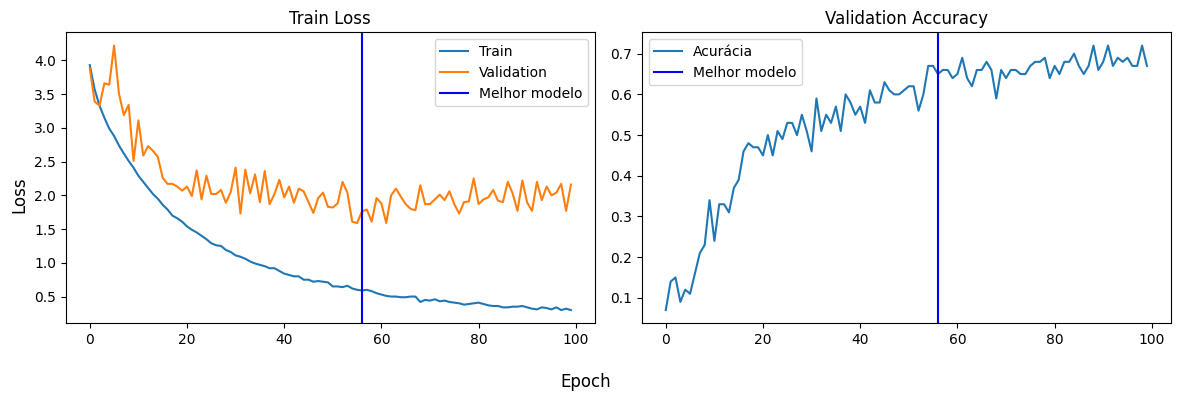

In [23]:
import matplotlib.pyplot as plt
import numpy as np

acc_1 = []
for i in hist_acc_validation_1:
    acc_1.append(i.cpu())

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Train Loss")
ax[0].plot(np.arange(len(hist_loss_train_1)), hist_loss_train_1, label='Train')
ax[0].plot(np.arange(len(hist_loss_validation_1)), hist_loss_validation_1, label='Validation')
ax[0].axvline(x=56, color='b', label='Melhor modelo')
ax[0].legend()

ax[1].set_title("Validation Accuracy")
ax[1].plot(np.arange(len(acc_1)), acc_1, label='Acurácia')
ax[1].axvline(x=56, color='b', label='Melhor modelo')
ax[1].legend()

fig.supxlabel('Epoch')
fig.supylabel('Loss')
fig.tight_layout()

plt.show()


## Treinamento 2

In [14]:
model.load_state_dict(torch.load('modelo_teste_1.pt'))
model = model.to(device)

hist_loss_train_2, hist_loss_validation_2,hist_acc_validation_2,best_epoca_2,best_acc_2 = train_n_epochs(model, optimizer, trainloader_2, validloader, testloader, 50, 'modelo_teste_2.pt')

Epoch 0: Train Loss: 1.09 Validation Loss: 2.04 Validation Accuracy: 0.62 Test Accuracy: 0.65
Epoch 1: Train Loss: 1.01 Validation Loss: 1.62 Validation Accuracy: 0.68 Test Accuracy: 0.68
Epoch 2: Train Loss: 0.99 Validation Loss: 1.91 Validation Accuracy: 0.63 Test Accuracy: 0.67
Epoch 3: Train Loss: 0.95 Validation Loss: 1.70 Validation Accuracy: 0.65 Test Accuracy: 0.70
Epoch 4: Train Loss: 0.91 Validation Loss: 1.81 Validation Accuracy: 0.64 Test Accuracy: 0.69
Epoch 5: Train Loss: 0.87 Validation Loss: 1.71 Validation Accuracy: 0.67 Test Accuracy: 0.68
Epoch 6: Train Loss: 0.87 Validation Loss: 1.76 Validation Accuracy: 0.66 Test Accuracy: 0.69
Epoch 7: Train Loss: 0.88 Validation Loss: 1.86 Validation Accuracy: 0.64 Test Accuracy: 0.71
Epoch 8: Train Loss: 0.82 Validation Loss: 1.92 Validation Accuracy: 0.67 Test Accuracy: 0.69
Epoch 9: Train Loss: 0.79 Validation Loss: 1.74 Validation Accuracy: 0.68 Test Accuracy: 0.71
Epoch 10: Train Loss: 0.80 Validation Loss: 1.68 Validation 

Gráfico

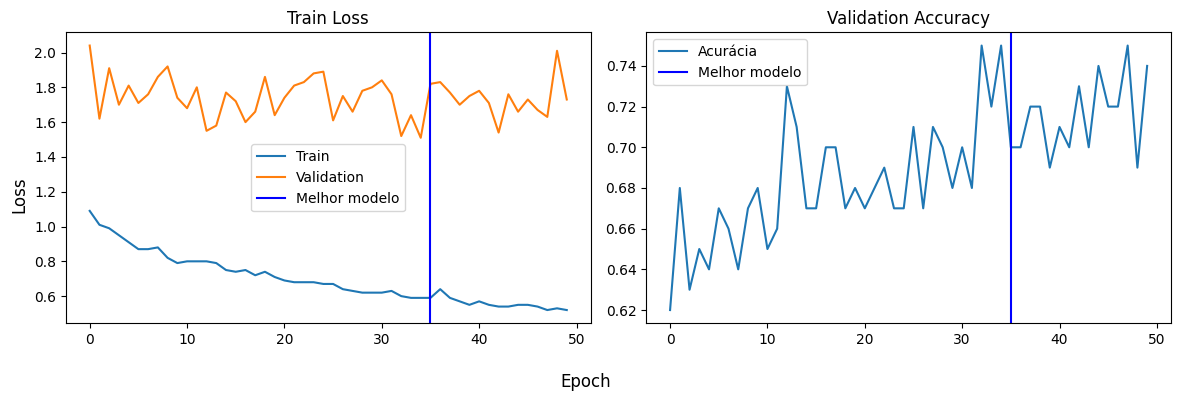

In [112]:
import matplotlib.pyplot as plt
import numpy as np
acc_2 = []
for i in hist_acc_validation_2:
    acc_2.append(i.cpu())
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Train Loss")
ax[0].plot(np.arange(len(hist_loss_train_2)), hist_loss_train_2, label='Train')
ax[0].plot(np.arange(len(hist_loss_validation_2)), hist_loss_validation_2, label='Validation')
ax[0].axvline(x=35, color='b', label='Melhor modelo')
ax[0].legend()

ax[1].set_title("Validation Accuracy")
ax[1].plot(np.arange(len(acc_2)), acc_2, label='Acurácia')
ax[1].axvline(x=35, color='b', label='Melhor modelo')
ax[1].legend()

fig.supxlabel('Epoch')
fig.supylabel('Loss')
fig.tight_layout()

plt.show()


## Treinamento 3

In [102]:

model.load_state_dict(torch.load('modelo_teste_2.pt'))
model = model.to(device)

hist_loss_train_3, hist_loss_validation_3,hist_acc_validation_3,best_epoca_3,best_acc_3 = train_n_epochs(model, optimizer, trainloader_3, validloader, testloader, 37, 'modelo_teste_3.pt')

Epoch 0: Train Loss: 1.21 Validation Loss: 1.74 Validation Accuracy: 0.70 Test Accuracy: 0.73
Epoch 1: Train Loss: 1.07 Validation Loss: 1.59 Validation Accuracy: 0.72 Test Accuracy: 0.73
Epoch 2: Train Loss: 1.05 Validation Loss: 1.47 Validation Accuracy: 0.72 Test Accuracy: 0.70
Epoch 3: Train Loss: 1.02 Validation Loss: 1.49 Validation Accuracy: 0.73 Test Accuracy: 0.73
Epoch 4: Train Loss: 0.99 Validation Loss: 1.52 Validation Accuracy: 0.74 Test Accuracy: 0.72
Epoch 5: Train Loss: 0.97 Validation Loss: 1.46 Validation Accuracy: 0.74 Test Accuracy: 0.72
Epoch 6: Train Loss: 0.98 Validation Loss: 1.51 Validation Accuracy: 0.72 Test Accuracy: 0.70
Epoch 7: Train Loss: 0.94 Validation Loss: 1.57 Validation Accuracy: 0.70 Test Accuracy: 0.71
Epoch 8: Train Loss: 0.93 Validation Loss: 1.50 Validation Accuracy: 0.71 Test Accuracy: 0.72
Epoch 9: Train Loss: 0.92 Validation Loss: 1.56 Validation Accuracy: 0.72 Test Accuracy: 0.72
Epoch 10: Train Loss: 0.90 Validation Loss: 1.35 Validation 

Gráfico

C:\Users\zabuz\AppData\Local\Temp\ipykernel_18836\3800636426.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


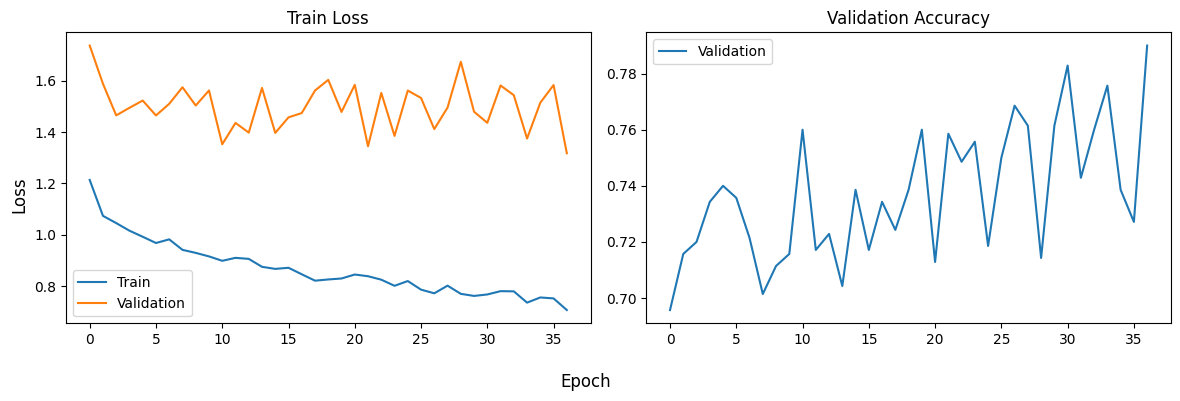

In [111]:

acc_3 = []
for i in hist_acc_validation_3:
    acc_3.append(i.cpu())


fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].title.set_text("Train Loss")
ax[0].plot(np.arange(len(hist_loss_train_3)), hist_loss_train_3, label = 'Train')
ax[0].plot(np.arange(len(hist_loss_validation_3)), hist_loss_validation_3, label = 'Validation')
ax[0].legend()

ax[1].title.set_text("Validation Accuracy")
ax[1].plot(np.arange(len(acc_3)), acc_3, label = 'Validation')
ax[1].legend()

fig.supxlabel('Epoch')
fig.supylabel('Loss')
fig.tight_layout()

fig.show()

# Resultados finais

In [113]:
model = DenseNet
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.load_state_dict(torch.load('modelo_teste_3.pt'))
model = model.to(device)

class_names = testset.classes
accuracy, conf, report = metricas(model, testloader, device, class_names)

print(report)

                   precision    recall  f1-score   support

           Afghan       0.77      1.00      0.87        10
 African Wild Dog       1.00      1.00      1.00        10
         Airedale       0.73      0.80      0.76        10
American Hairless       0.80      0.80      0.80        10
 American Spaniel       0.64      0.70      0.67        10
          Basenji       0.38      0.90      0.53        10
           Basset       0.82      0.90      0.86        10
           Beagle       0.89      0.80      0.84        10
   Bearded Collie       0.90      0.90      0.90        10
         Bermaise       0.91      1.00      0.95        10
     Bichon Frise       1.00      1.00      1.00        10
         Blenheim       0.77      1.00      0.87        10
       Bloodhound       0.83      1.00      0.91        10
         Bluetick       0.71      1.00      0.83        10
    Border Collie       0.89      0.80      0.84        10
           Borzoi       1.00      0.60      0.75       

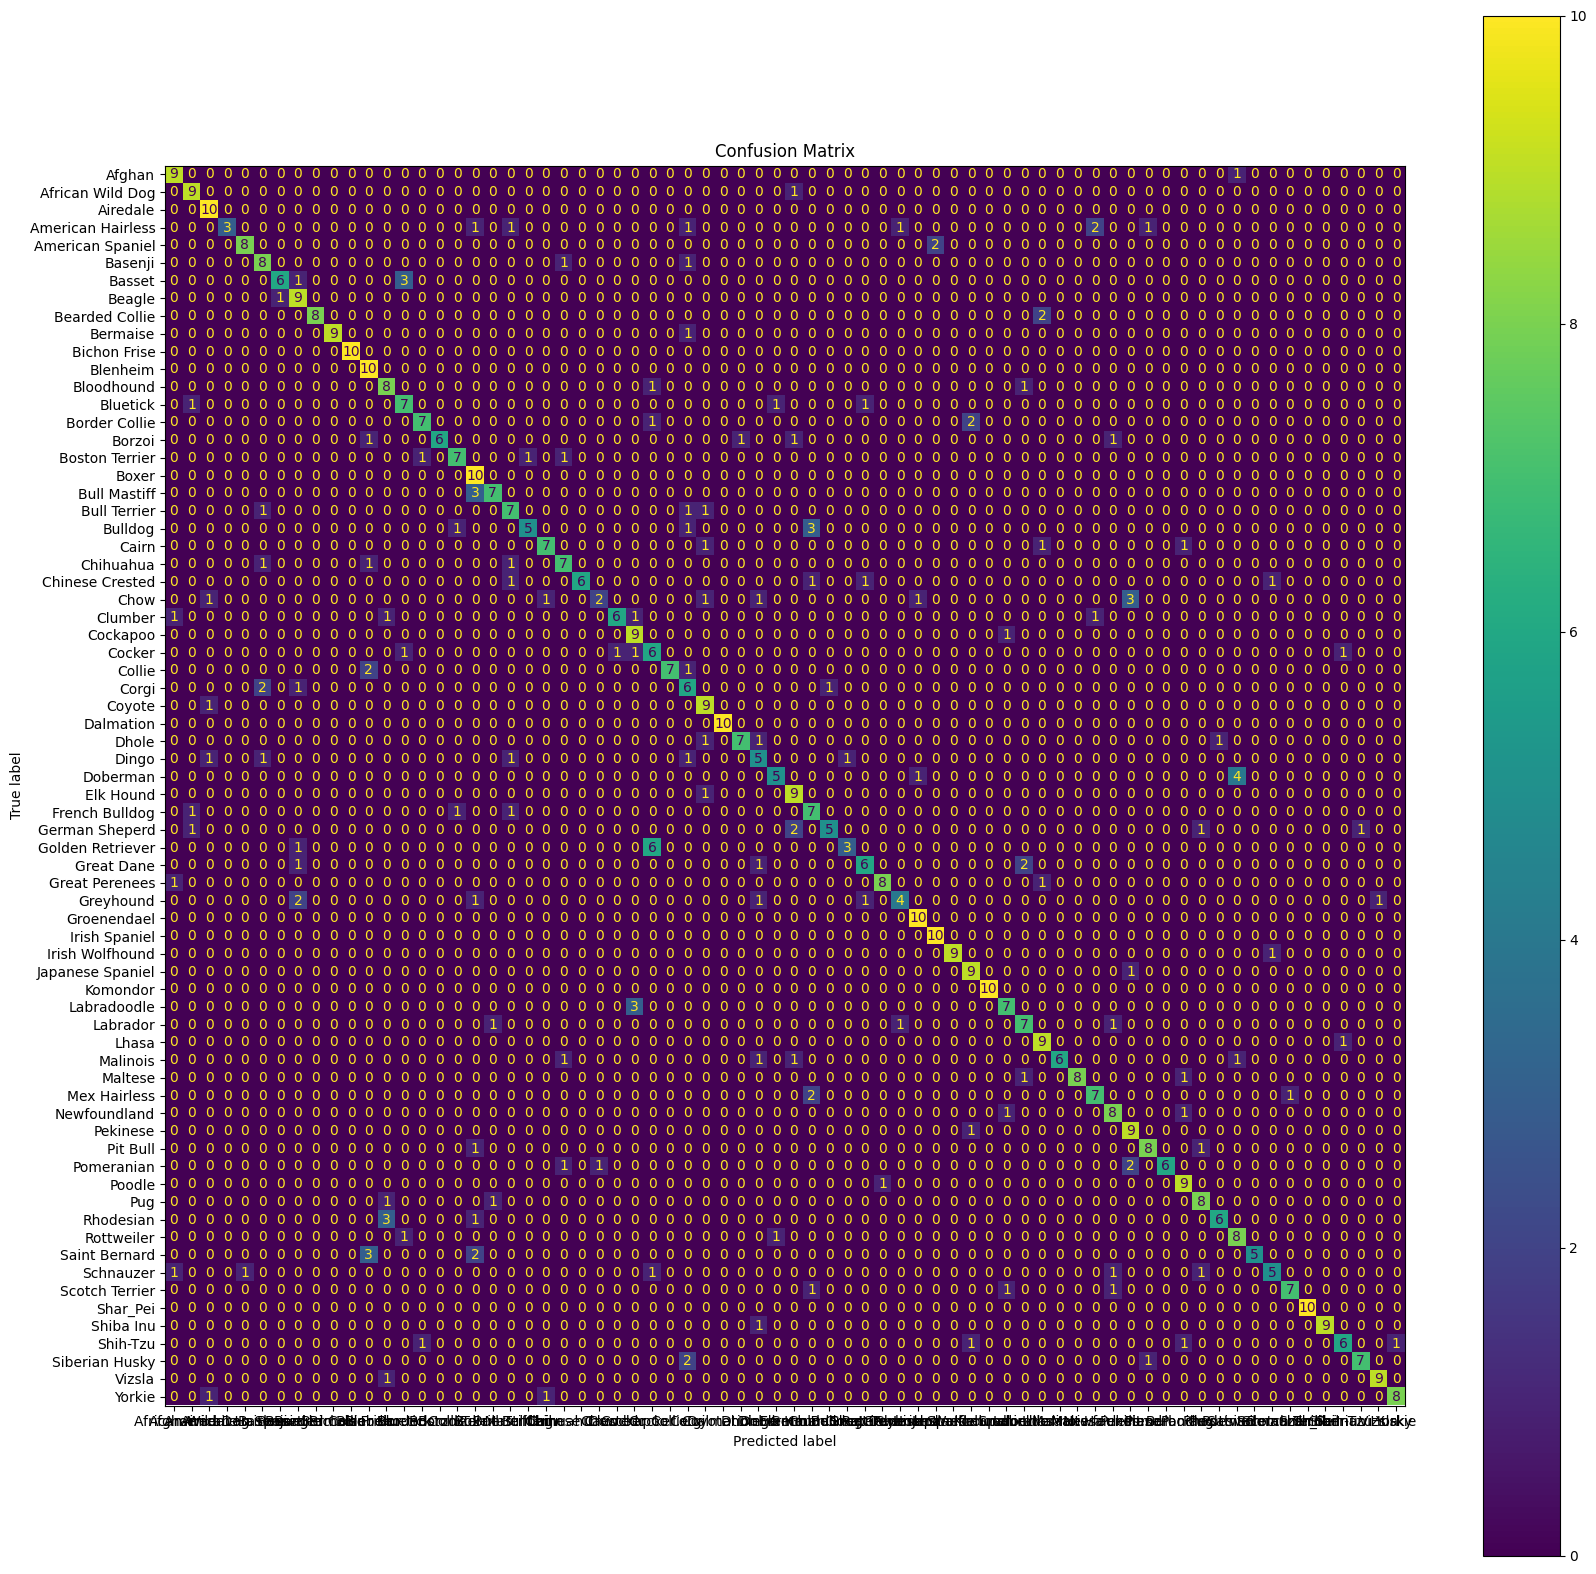

In [101]:
from sklearn.metrics import ConfusionMatrixDisplay


fig, ax = plt.subplots(figsize=(20,20), dpi=100)


display = ConfusionMatrixDisplay(conf, display_labels=class_names)


ax.set(title='Confusion Matrix')


display.plot(ax=ax);

# Conclusão final

A DenseNet foi implementada com sucesso, com suas próprias diferenças da original, e conseguiu fazer um bom ajuste dos dados chegando a ter uma acurácia de 0.8 no terceiro treinamento, sendo esse treinado apenas com apenas 37 épocas. Imagino que se esse terceiro treinamento fosse executado por mais 50 épocas seria possível encontrar um modelo melhor. 